In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
from collections import Counter
import tqdm
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from wordcloud import WordCloud, STOPWORDS
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from sklearn.cluster import AffinityPropagation
from IPython.display import display
from matplotlib import pyplot
from sklearn.decomposition import PCA
%matplotlib inline

C:\Users\tooba\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data = pd.read_csv('articles.csv')
data.head()

,index,URL,Headline,Date,Content,Author
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn


#### Preprocessing

 - Let's see the distribution of words in the articles
 - Once we get the labels we can compare the length of the fake vs real articles

In [3]:
length = np.array(list(map(len, data['Content'].str.split(' '))))
print("Average number of words in an article is: {}.".format(np.mean(length)))
print("Minimum number of words in an article is: {}.".format(min(length)))
print("Maximum number of words in an article is: {}.".format(max(length)))

Average number of words in an article is: 487.5427135678392.
Minimum number of words in an article is: 75.
Maximum number of words in an article is: 3308.


C:\Users\tooba\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


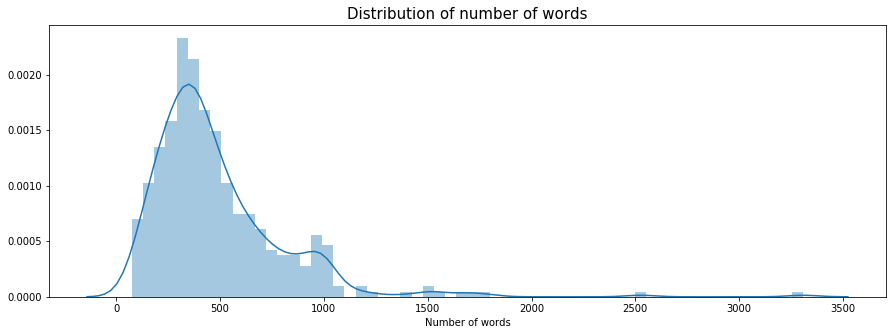

In [4]:
fig, a = plt.subplots(figsize=(15,5))
a.set_title("Distribution of number of words", fontsize=15)
a.set_xlabel("Number of words")
sns.distplot(length, bins=60, ax=a);

In [5]:
print("There are {} articles with greater than 1000 words.".format(sum(length > 1000)))

There are 20 articles with greater than 1000 words.


 - We will only tokenize and remove some punctuation for the Word2Vec model since the model can determine by itself what words are important and what needs to be discarded. That's why for now we aren't removing the stopwords.
 - Can fine-tune the preprocessing of Word2Vec based on how the model performs

In [6]:
def tokens(sentence):
    replace = list(map(lambda x: re.sub('[^0-9A-Za-z!?]+', '', x), sentence))
    remove = list(filter(lambda x: x, replace))
    return remove

In [7]:
def preprocessing(data):
    data['tokenized'] = data['Content'].str.lower() #lower
    data['tokenized'] = data['tokenized'].str.split('.')  #sentences
    data['tokenized'] = list(map(lambda x: list(map(nltk.word_tokenize, x)), data['tokenized'])) 
    data['tokenized'] = list(map(lambda x: list(map(tokens, x)), data['tokenized']))  # remove unwanted chars
    data['tokenized'] = list(map(lambda x: list(filter(lambda lst: lst, x)), data['tokenized']))  # remove empty lists

preprocessing(data)

In [8]:
s = []
for i in data['tokenized']:
    s.extend(i)
print("Total number of sentences in all the articles: {}.".format(len(s)))
print("Total articles: {}.".format(len(data)))

Total number of sentences in all the articles: 8409.
Total articles: 398.


#### Word2Vec
The following approaches can be tested
 - Use Google pre-trained model and create features based on that for the current dataset
 - Finetune the google pre-trained model for our dataset
 - Training from scratch (Won't really work because the neural network needs alot of data to learn the weights)
 - For parameters we can finetune the model based on both Continous bag of words and skip grams.

In [9]:
os.chdir('E:\Courses\Projects\Surkhi Material')

In [10]:
os.getcwd()

'E:\\Courses\\Projects\\Surkhi Material'

#### Google Word2Vec

In [11]:
# Load Google's pre-trained Word2Vec model.
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True) 
# model.vector_size

In [14]:
# model.save("google_model")

In [12]:
print(model.wv.similarity(w1="politics",w2="election"))
print(model.wv.similarity(w1="express",w2="news"))
print(model.wv.similarity(w1="dawn",w2="news"))
print(model.wv.similarity(w1="dawn",w2="express"))
print(model.wv.similarity(w1="pti",w2="election"))

C:\Users\tooba\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\tooba\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.41703448


C:\Users\tooba\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


0.07247438


C:\Users\tooba\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


0.20080201


C:\Users\tooba\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


0.012489323


C:\Users\tooba\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


0.008988038


- We can see from the above similarity score that we need to fine tune the model for our data since the context for the news here is different.

#### Fine-tune 

In [ ]:
# Cannot run on this machine
model = Word2Vec.load("google_model")
model.train(documents =s,total_examples = len(s), epochs = self.iter)

#### Train from Scratch

#### Observations
 - If we use sg = 1 (skip-gram model) for word2vec then the model perfoms worse. The model performs better with sg = 0 (Continous Bag of words) since skip-gram performs better in the case of a large corpus which isn't the case for our dataset.
 - We are using hs = 0 (hierarchial sampling) instead of hs = 1 (negative sampling) because the latter is typically preferred for large corpus.
 - Window size: As we reduce the window size the similarity score between the same context words is imporving.
 -Downsampling : Since the neural network has 1 hidden layers and 1 output layer so the total number of weights (matrix) for each layer are going to be 200 x 6426 (features x vocabulary) which is alot.We will need a huge amount of training data in order to tune these weights and avoid over-fitting.Hence we subsample frequent words to decrease the number of training examples.

In [12]:
# Train on the current dataset
num_features = 200    
count = 3    
context = 2           
downsampling = 1e-3   # threshold for configuring which higher-frequency words are randomly downsampled
model = Word2Vec(sentences=s,sg=0,hs=0,size=num_features,min_count=count,window=context,sample=downsampling,
                 iter=20,compute_loss = True)

In [17]:
model.get_latest_training_loss()

2320115.0

In [21]:
model.most_similar(["pti"],topn=10)

C:\Users\tooba\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ppp', 0.8918001055717468),
 ('pmln', 0.8917306661605835),
 ('opposition', 0.8003404140472412),
 ('leadership', 0.7986245155334473),
 ('alliance', 0.7851901650428772),
 ('sindh', 0.7809574007987976),
 ('mqm', 0.7788859605789185),
 ('federal', 0.7682009935379028),
 ('gda', 0.7676957249641418),
 ('provincial', 0.7639607191085815)]

- From the above similarity we can see that the model is generalizing according to the Pakistani news context. 

In [10]:
print(model.wv.similarity(w1="politics",w2="election"))
print(model.wv.similarity(w1="express",w2="news"))
print(model.wv.similarity(w1="dawn",w2="news"))
print(model.wv.similarity(w1="dawn",w2="express"))
print(model.wv.similarity(w1="pti",w2="election"))


C:\Users\tooba\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5110972
0.68454623
0.68404645
0.7938115
0.64978504


- We can see from the above similarity score that if we train the model for our data then it works better.

In [11]:
len(model.wv.vocab.keys())

6426

 - To find the article level embeddings we can average out the word embeddings for each word in the article. As a result we get features for each individual article.
 - The averaging is also used because we only care about the context of the surrounding words and not their order so to ensure that we take the average.



In [ ]:
# Creating features using the pre-trained model
def features(model, sentence_list):
#concatenates all the words in the sentences for an article    
    words = np.concatenate(sentence_list)  
    model_words = set(model.wv.vocab.keys())
    feature_size = model.vector_size
    features = np.zeros(feature_size,dtype="float32")
    total_words = 0
#  if the article word is in the model's vocabulary then add its feature vector to the total
    for word in words:
        if word in model_words:
            features = np.add(features, model[word])
            total_words+= 1

    # Divide the result by the number of words to get the average
    if total_words > 0:
        features = np.divide(features, total_words)
    return features

data['w2v_features'] = list(map(lambda sentence_list: features(model,sentence_list), data['tokenized']))